# <b>Project #1 - Exploratory data analysis</b>

## <b>Import used packages</b>

In [617]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.preprocessing, sklearn.cluster, sklearn.metrics
import scipy.spatial
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, DBSCAN
import re

## <b>Loading data from - in our case it is a csv file</b>

In [618]:
df_full = pd.read_csv('./googleplaystore.csv', sep=',') 

## <b>Let's take a look at the basic dataset information</b>

### <b>Dataset columns?</b>
- App: Application Name
- Category: Category the app belongs to
- Rating: Overall user rating of the app
- Reviews: Number of user reviews for the app
- Size: Size of the app
- Installs: Number of user downloads/installs for the app
- Type: Paid or Free
- Price: Price of the app
- Content Rating: Age group the app is targeted at
- Genres: An app can belong to multiple genres
- Last updated: Date when the app was last updated on Play Store
- Current Ver: Current version of the app available on Play Store
- Andoird Ver: Min. required Android version


### <b>Dataset shape?</b>
- 13 cols, 10841 rows


### <b>It would be better to edit and convert columns to correct datatypes</b>
1. Price has dollar sign before value, it would be better to remove dollar sign and convert into numeric value
2. Reviews should be integer
3. Created new col Size Numeric, M and k units removed and k calculated to M 
4. Let's create a new column with the min required android version rounded to an integer
5. Let's create a new column with the current version of app rounded to an integer
6. Let's create Int number from installs 

In [619]:
# there was a one incorrect record, cells was wrongly sorted
df_full = df_full.loc[df_full['App'] !=
                      'Life Made WI-Fi Touchscreen Photo Frame']

# -------- 1. --------
df_full['Price'] = df_full['Price'].str.replace(
    '$', '', regex=True).astype(float)

# -------- 2. --------
df_full['Reviews'] = pd.to_numeric(df_full["Reviews"])

# -------- 3. --------
df_full['Size'] = df_full['Size'].apply(lambda x: round(
    float(x.replace('k', '')) / 1024, 1) if 'k' in x else x.replace('M', ''))
df_full['Size'] = df_full['Size'].loc[df_full['Size']
                                                      != 'Varies with device'].astype(float)

# -------- 4. --------
df_full['Android Ver'] = df_full.loc[df_full['Android Ver']
                                             != 'Varies with device']['Android Ver']
df_full['Android Ver'] = df_full['Android Ver'].apply(lambda x: re.search(
    '[0-9]+', str(x)).group() if re.search('[0-9]+', str(x)) else 0).astype(int)

# -------- 5. --------
df_full['Current Ver'] = df_full.loc[df_full['Current Ver']
                                             != 'Varies with device']['Current Ver']
df_full['Current Ver'] = df_full['Current Ver'].apply(lambda x: re.search(
    '[0-9]+', str(x)).group()[0] if re.search('[0-9]+', str(x)) else 0).astype(int)

# -------- 6. --------
df_full['Installs'] = df_full['Installs'].apply(lambda x: str(x).replace('+', '').replace(',', '')).astype(int)


### <b>Next step is to remove useless cols for clustering</b>
- App name is useless for clustering
- Genres contain list, it's difficult to work with values
- Last updated could be categorized, but there would be many categories, I've decided to not include this col into clustering

In [620]:
df_full.drop('App', axis=1, inplace=True)
df_full.drop('Genres', axis=1, inplace=True)
df_full.drop('Last Updated', axis=1, inplace=True)

### <b>Are there any missing values?</b>
- Mostly not, a few columns have negligibly few missing values
- Rating has cca 1/11 of records empty
- Size empty values are records with value equals to 'Varies with device'

In [621]:
df_full.isna().sum().sort_values()

Category             0
Reviews              0
Installs             0
Price                0
Content Rating       0
Current Ver          0
Android Ver          0
Type                 1
Rating            1474
Size              1695
dtype: int64

### <b>Let's fill missing values with mean or remove them</b>

In [622]:
rating_mean_value=df_full['Rating'].mean()
df_full['Rating'].fillna(value=rating_mean_value, inplace=True)

size_mean_value=df_full['Size'].mean()
df_full['Size'].fillna(value=size_mean_value, inplace=True)

df_full=df_full.dropna(subset=['Type'])

## <b>Next step is encode some of non-numeric values (first part of preprocessing)</b>

#### <b>Save dataset before preprocessing</b>

In [623]:
df = df_full

#### <b>First is Type which contain two values (Free or Paid)</b>
- Because we have only 2 values, we will use Label encoder

In [624]:
df_full['Type'].value_counts()
df_full['Type'] = sklearn.preprocessing.LabelEncoder().fit_transform(df_full['Type'])

#### <b>Second is Content Rating which contain multiple values (5)</b>
- In this case, we can specify order, so we will use Ordinal encoder with defined order
    - I'll set the order according to the size of the age interval
        - Teen <13;19>
        - Adults only 18+ <18;∞>
        - Mature 17+ <17;∞>
        - Everyone 10+ <10;∞>
        - Everyone <0;∞>
        - Unrated <0;∞>


In [625]:
df_full['Content Rating'].value_counts()
categories = ['Teen','Adults only 18+', 'Mature 17+', 'Everyone 10+', 'Everyone', 'Unrated']

enc = sklearn.preprocessing.OrdinalEncoder(categories = [categories])
df_full['Content Rating'] = enc.fit_transform(df_full[['Content Rating']])

#### <b>Third is Category which contain multiple values (33)</b>
- Data are nominal, so we don't have to use Ordinal encoder.
- If we would use label encoding, category names would be ranked based on the alphabets. It would create bad relationships between categories. We should use One-hot encoding, but we have high number of categories, which isn't good.
- So I've decided to consider only 10 most frequented categories and create "Others" category for the rest.
- After these steps I'll use One-hot encoding via get_dummies approach.

In [626]:
top_10_categories = df_full['Category'].value_counts().head(10).keys()
df_full['Category'] = df_full['Category'].apply(lambda x: "OTHER" if x not in str(top_10_categories) else x)

df_full = pd.get_dummies(df_full, columns = ['Category'])

## <b>All data are numerical for now</b>

### <b>We've done Encoding, which is preprocessing method, but let's try more of preprocessing</b>
-  The dataset is preprocessed in order to check missing values, noisy data, and other inconsistencies before executing it to the algorithm.

#### <b>MinMaxScaler preprocessing </b>
- The motivation to use this scaling include robustness to very small standard deviations of features and preserving zero entries in sparse data.
- I'll to that because of some cols contain big numbers (installs).

In [627]:
scaler = sklearn.preprocessing.MinMaxScaler()
df_min_max_scaled = scaler.fit_transform(df_full)

#### <b>RobustScaler preprocessing </b>
- PowerTransformer applies a power transformation to each feature to make the data more Gaussian-like in order to stabilize variance and minimize skewness.

In [628]:
scaler = sklearn.preprocessing.RobustScaler()
df_robust_scaled = scaler.fit_transform(df_full)

#### <b>MaxAbs preprocessing </b>
- I wanted to use MaxAbs, but dataset contain positive values only, it means that result would be same as MinMaxScaler

## <b>Let's try 3 clustering methods (combination of preprocessing and clustering methods)</b>
1. <b>K-means</b> + <b>Robust scaled data</b>
2. <b>K-means</b> + <b>MinMax scaled data</b>
3. <b>Agglomerative</b> + <b>MinMax scaled data</b>


### <b>Let's create reusable function for Elbow method</b>


In [629]:
def elbow_method(data):
    clustering_scores = []
    for k in range(2, 12):
        clustering = sklearn.cluster.KMeans(n_clusters=k).fit(data)

        clustering_scores.append({
            'k': k,
            'sse': clustering.inertia_,
        })
    df_clustering_scores = pd.DataFrame.from_dict(clustering_scores, orient='columns')

    return df_clustering_scores

### <b>1. K-means + Robust scaled data


#### <b>Let's find the most ideal number of clusters</b>
- Number of clusters: <b>5</b>
- I guess I could use 8, but the result is 8 clusters where one is really big and the other clusters are just small (like 5).


<AxesSubplot: xlabel='k', ylabel='sse'>

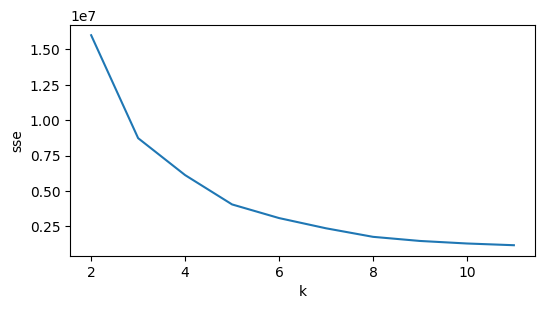

In [630]:
fig = plt.figure(figsize=(6,3))
sns.lineplot(data=elbow_method(df_robust_scaled), x='k', y='sse')

#### <b>Creating clusters</b>
- When I changed the random_stat from 9 to 10, the size of the clusters changed.

In [631]:
clust = sklearn.cluster.KMeans(n_clusters=5, random_state = 10)
clust.fit(df_robust_scaled)
df['cluster_id'] = clust.labels_
pd.Series(clust.labels_).value_counts()

0    10409
4      324
2       71
3       18
1       17
dtype: int64

#### <b>Visualization

<AxesSubplot: xlabel='cluster_id', ylabel='count'>

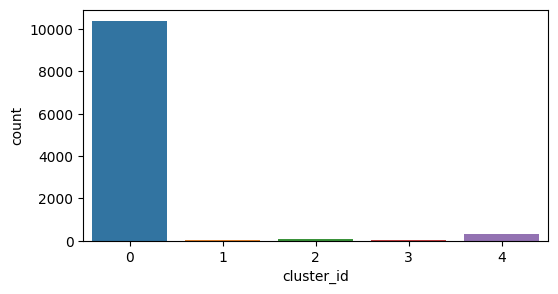

In [632]:
fig = plt.figure(figsize=(6,3))
sns.countplot(data=df, x='cluster_id')

<AxesSubplot: xlabel='cluster_id', ylabel='Rating'>

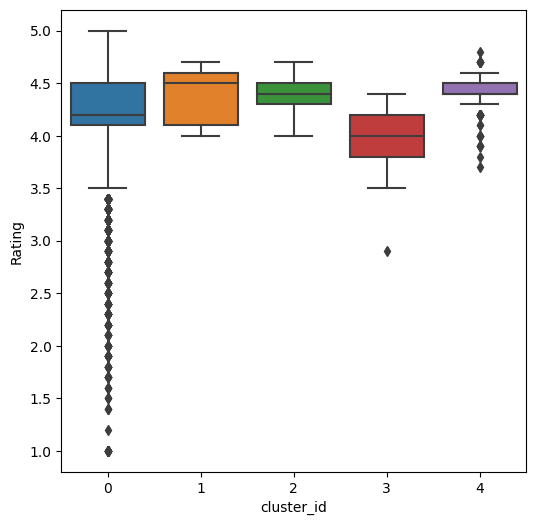

In [633]:
fig = plt.figure(figsize=(6,6))
sns.boxplot(data=df, x='cluster_id', y='Rating')

<AxesSubplot: xlabel='cluster_id', ylabel='Installs'>

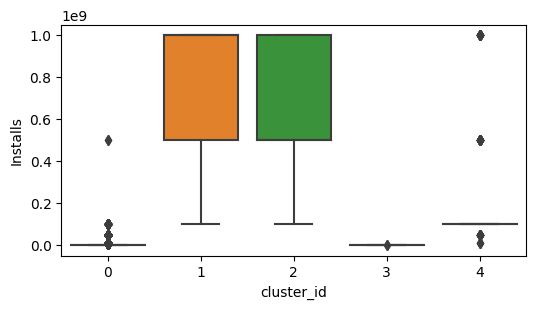

In [634]:
fig = plt.figure(figsize=(6,3))
sns.boxplot(data=df, x='cluster_id', y='Installs')

<AxesSubplot: xlabel='cluster_id', ylabel='Price'>

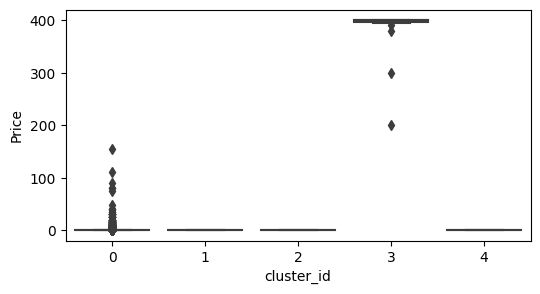

In [635]:
fig = plt.figure(figsize=(6,3))
sns.boxplot(data=df, x='cluster_id', y='Price')

#### <b>Description</b>
- We can see that the clusters are very unbalanced, the cluster with id 0 contain 10409 records, the cluster with id 1 contain 324 records and the rest under 100 records.
- In terms of ratings, the cluster with id 3 contain the lowest rated applications, otherwise it is quite similar.
- The clusters that contain significantly the most installed applications are clearly 1 and 2.
- Cluster with id 3 contain only Paid apps, cluster with id 0 contain both Free and Paid apps, other clusters contain only Free apps


### <b>2. K-means + MinMax scaled data</b>


#### <b>Let's find the most ideal number of clusters</b>
- In this case that is not that clear, but we can consider <b>5 clusters</b> as acceptable


<AxesSubplot: xlabel='k', ylabel='sse'>

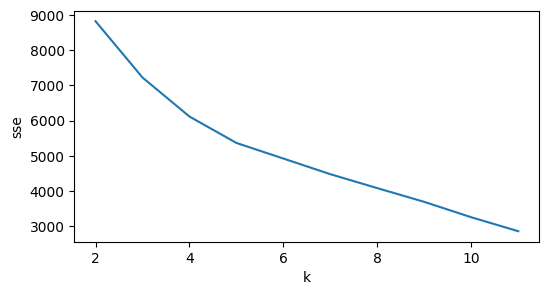

In [636]:
fig = plt.figure(figsize=(6,3))
sns.lineplot(data=elbow_method(df_min_max_scaled), x='k', y='sse')

#### <b>Creating clusters</b>
- When I've changed random_stat from 10 to 11, size of clusters changed, from 11 no effect

In [637]:
clust = sklearn.cluster.KMeans(n_clusters=5, random_state = 11)
clust.fit(df_min_max_scaled)
df['cluster_id'] = clust.labels_
pd.Series(clust.labels_).value_counts()

0    3989
3    2892
1    1971
4    1144
2     843
dtype: int64

#### <b>Visualization


<AxesSubplot: xlabel='cluster_id', ylabel='count'>

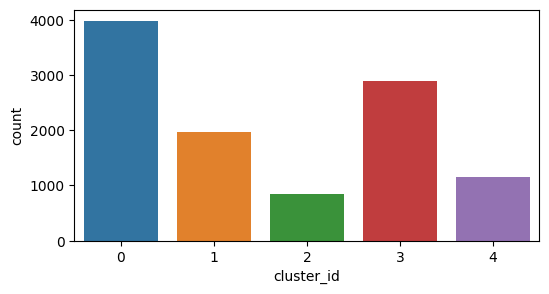

In [638]:
fig = plt.figure(figsize=(6,3))
sns.countplot(data=df, x='cluster_id')

<AxesSubplot: xlabel='cluster_id', ylabel='Rating'>

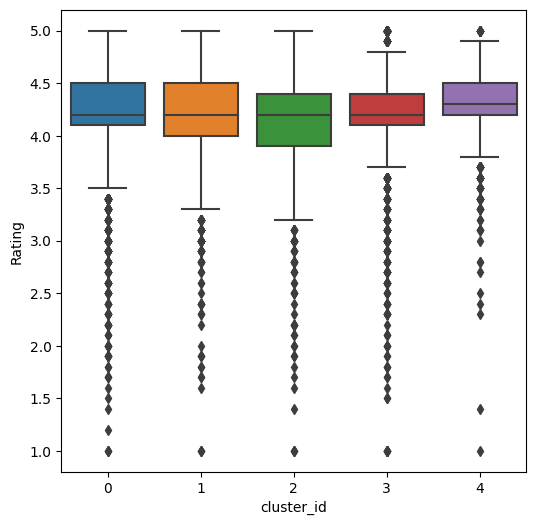

In [639]:
fig = plt.figure(figsize=(6,6))
sns.boxplot(data=df, x='cluster_id', y='Rating')

<AxesSubplot: xlabel='cluster_id', ylabel='Installs'>

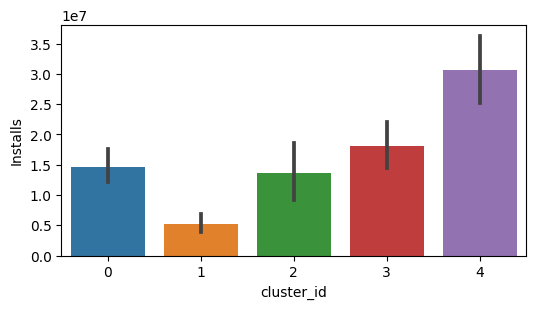

In [640]:
fig = plt.figure(figsize=(6,3))
sns.barplot(data=df, x='cluster_id', y='Installs')

<AxesSubplot: xlabel='cluster_id', ylabel='Price'>

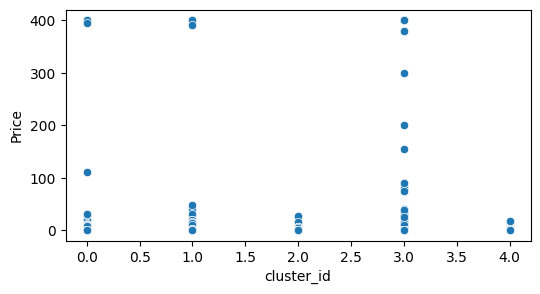

In [641]:
fig = plt.figure(figsize=(6,3))
sns.scatterplot(data=df, x='cluster_id', y='Price')

#### <b>Description</b>
- the cluster with id 0 contain the most applications, the second cluster is the cluster with id 3, the pot is the cluster with id 1 and the other two clusters have a similar number of applications.
- In terms of rankings, the clusters were distributed quite evenly.
- Cluster with id 1 contain the less installed apps, the most installed apps contain cluster with id 4.
- All of generated clusters contain Paid apps.

### <b>3. Agglomerative + MinMax scaled data</b>


#### <b>Let's find the most ideal number of clusters</b>
- We did that in the second observation
- Number of clusters: <b>5


#### <b>Creating clusters</b>
- I've used complete linkage, consider average distance from point to cluster
- Other parametres are for specific cases in my opinion (compute_full_tree for more clusters, compute_distances for dendrogram visualizition, etc.)

In [642]:
clust = sklearn.cluster.AgglomerativeClustering(n_clusters=5, linkage='average')
clust.fit(df_min_max_scaled)
df['cluster_id'] = clust.labels_
pd.Series(clust.labels_).value_counts()

0    8453
4    1144
3     463
2     392
1     387
dtype: int64

#### <b>Visualization


<AxesSubplot: xlabel='cluster_id', ylabel='count'>

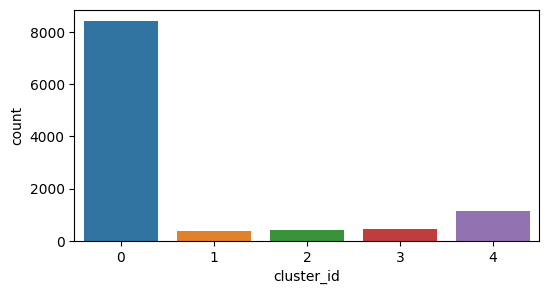

In [643]:
fig = plt.figure(figsize=(6,3))
sns.countplot(data=df, x='cluster_id')

<AxesSubplot: xlabel='cluster_id', ylabel='Rating'>

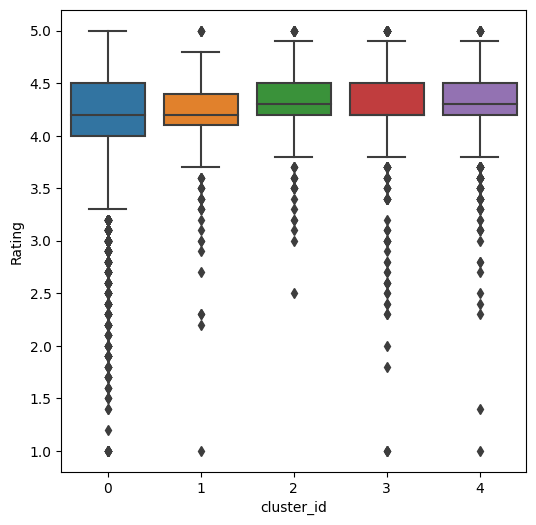

In [644]:
fig = plt.figure(figsize=(6,6))
sns.boxplot(data=df, x='cluster_id', y='Rating')

<AxesSubplot: xlabel='cluster_id', ylabel='Installs'>

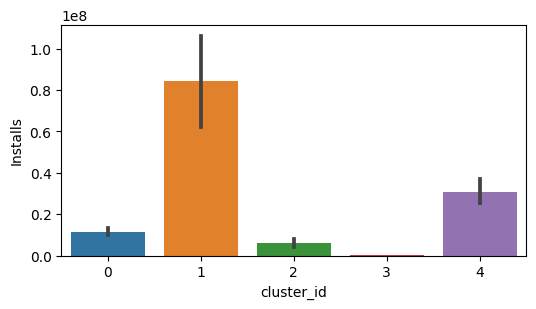

In [645]:
fig = plt.figure(figsize=(6,3))
sns.barplot(data=df, x='cluster_id', y='Installs')

<AxesSubplot: xlabel='cluster_id', ylabel='Price'>

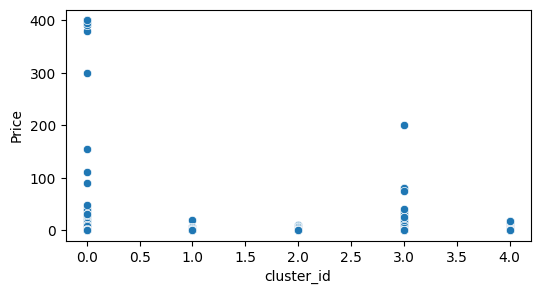

In [650]:
fig = plt.figure(figsize=(6,3))
sns.scatterplot(data=df, x='cluster_id', y='Price')

#### <b>Description</b>
- Cluster with id 0 contain most applications.
- The rating is evenly distributed among the clusters, so it did not play a big role in the formation of the cluster.
- The most installed applications are in cluster 1, followed by cluster 4, then almost evenly 0 and 2 and the last cluster 3 with the lowest number of installations. 
- Again all clusters contain paid apps, the most expensive apps are in clusters 0 and 3, the others are relatively even.


# <b>Final report</b>
 A dataset analysis was performed on android apps available through Google Play. The whole dataset was converted to numeric values and columns that do not make sense for clustering, such as the application name were removed. MinMax Scaler and Robust scaler were used for preprocessing (described in detail in the respective sections). For clustering I chose probably the most well-known K-means method and the Agglumerative method. When using a combination of Robust scaler preprocessing and the K-means method, the clusters were similarly distributed as when using Agglumerative clustering and MinMax scaler preprocessing. K-means + Robust scaled data split the clusters according to whether they are paid or free. K-means + Robust scaled data clustered by number of installations. More detailed descriptions are given in the relevant sections. I think that the main factors for clustering used to be mostly the number of installations, price, and definitely the original categories. It was interesting to try different types of preprocessing and clustering methods for the selected dataset.